## Налаштування моделі багатошарового персептрона для класифікації зображень

#### Імпорт необхідних бібліотек

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import struct
import tensorflow as tf
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad
from PIL import Image

#### Імпорт датасету

In [2]:
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = (images / 255.)
 
    return images, labels

In [3]:
X_train, y_train = load_mnist('C:\\Users\\User\\Desktop\\Dataset', kind='train')
print('Train rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))
X_test, y_test = load_mnist('C:\\Users\\User\\Desktop\\Dataset', kind='t10k')
print('Test rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Train rows: 60000, columns: 784
Test rows: 10000, columns: 784


In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
y_train = tf.one_hot(y_train, depth=10)
y_test = tf.one_hot(y_test, depth=10)
y_val = tf.one_hot(y_val, depth=10)
y_train_graph = np.argmax(y_train, axis=1)
y_test_graph = np.argmax(y_test, axis=1)
y_val_graph = np.argmax(y_val, axis=1)

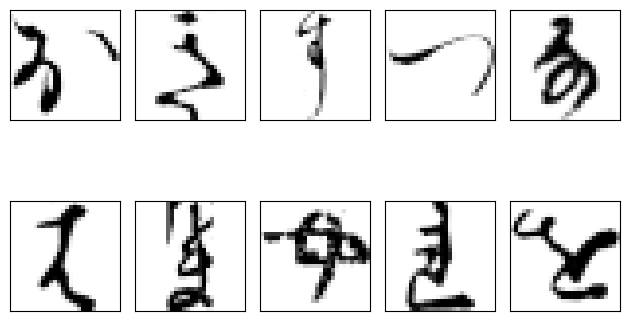

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train_graph == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [6]:
X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)
X_val = tf.cast(X_val, dtype=tf.float32)
y_val = tf.cast(y_val, dtype=tf.float32)

#### Допоміжні функції

In [7]:
def plot_metrics(losses_list, accuracies_list, titles):
    num_plots = len(losses_list)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    for i in range(num_plots):
        train_losses, val_losses = losses_list[i]
        title = titles[i]
        epochs = range(1, len(train_losses) + 1)
        plt.plot(epochs, train_losses, label=title)
        
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Losses")

    plt.subplot(1, 2, 2)
    for i in range(num_plots):
        train_accuracies, val_accuracies = accuracies_list[i]
        title = titles[i]
        epochs = range(1, len(train_accuracies) + 1)
        plt.plot(epochs, train_accuracies, label=title)
        
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training Accuracies")

    plt.show()
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i in range(num_plots):
        train_losses, val_losses = losses_list[i]
        title = titles[i]
        epochs = range(1, len(train_losses) + 1)
        plt.plot(epochs, val_losses, label=title)
        
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Validation Losses")

    plt.subplot(1, 2, 2)
    for i in range(num_plots):
        train_accuracies, val_accuracies = accuracies_list[i]
        title = titles[i]
        epochs = range(1, len(train_accuracies) + 1)
        plt.plot(epochs, val_accuracies, label=title)
        
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Validation Accuracies")

    plt.show()

In [10]:
def fit(model, learning_rate, epochs, batch_size, X_train, y_train, X_val, y_val):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        epoch_losses, epoch_accuracies = [], []

        for i in range(0, len(X_train), batch_size):
            x_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]
            epoch_losses.append(train_step(model, x_batch, y_batch, learning_rate).numpy())
            batch_predictions = model(x_batch)
            correct_predictions = tf.equal(tf.argmax(batch_predictions, 1), tf.argmax(y_batch, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
            epoch_accuracies.append(accuracy.numpy())

        val_predictions = model(X_val)
        val_correct_predictions = tf.equal(tf.argmax(val_predictions, 1), tf.argmax(y_val, 1))
        train_losses.append(np.mean(epoch_losses))
        val_losses.append(model.loss_function(y_val, val_predictions).numpy())
        train_accuracies.append(np.mean(epoch_accuracies))
        val_accuracies.append(tf.reduce_mean(tf.cast(val_correct_predictions, tf.float32)).numpy())
        
        if not ((epoch+1) % 10): 
            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")
            
    return train_losses, val_losses, train_accuracies, val_accuracies

#### Модель із єдиним вихідним шаром

In [11]:
class SimpleModel(Model):
    def __init__(self, input_shape, num_classes):
        super(SimpleModel, self).__init__()
        self.layer = keras.layers.Dense(num_classes, input_shape=input_shape, activation='softmax')

    def call(self, x):
        x = self.layer(x)
        return x

In [12]:
batch_size = 32
epochs = 50
learning_rate = 0.1
model_softmax = SimpleModel(X_train.shape[1:], y_train.shape[1])
model_softmax.compile(optimizer=SGD(learning_rate = 0.1), loss='categorical_crossentropy', metrics=['accuracy'])
result_softmax = model_softmax.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=0)

In [13]:
print("loss: {}, \nval_loss: {}, \naccuracy: {}, \nval_accuracy: {}".format(result_softmax.history['loss'][-1], 
                                                                      result_softmax.history['val_loss'][-1], 
                                                                      result_softmax.history['accuracy'][-1], 
                                                                      result_softmax.history['val_accuracy'][-1]))

loss: 0.5372610092163086, 
val_loss: 0.6531031727790833, 
accuracy: 0.8385624885559082, 
val_accuracy: 0.8109166622161865


#### Глибокі моделі з кількома прихованими шарами ReLu та Tanh

In [91]:
class MultimodelBase(Model):
    def __init__(self, input_shape, num_classes, activation, kernel_initializer, kernel_regularizer=None):
        super(MultimodelBase, self).__init__()
        self.layer1 = keras.layers.Dense(256, input_shape=input_shape, activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)
        self.layer2 = keras.layers.Dense(128, activation=activation, kernel_initializer=kernel_initializer)
        self.out = keras.layers.Dense(num_classes, activation='softmax')

    def call(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.out(x)

In [15]:
model_relu = MultimodelBase(X_train.shape[1:], y_train.shape[1], activation='relu', kernel_initializer = 'glorot_uniform')
model_relu.compile(optimizer=SGD(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

model_tanh = MultimodelBase(X_train.shape[1:], y_train.shape[1], activation='tanh', kernel_initializer = 'he_uniform')
model_tanh.compile(optimizer=SGD(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
batch_size = 128
result_relu = model_relu.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=0)
result_tanh = model_tanh.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=0)

Метрики ReLu

In [17]:
print("loss: {}, \nval_loss: {}, \naccuracy: {}, \nval_accuracy: {}".format(result_relu.history['loss'][-1], 
                                                                      result_relu.history['val_loss'][-1], 
                                                                      result_relu.history['accuracy'][-1], 
                                                                      result_relu.history['val_accuracy'][-1]))

loss: 0.0017673196271061897, 
val_loss: 0.20978179574012756, 
accuracy: 0.999833345413208, 
val_accuracy: 0.9556666612625122


Метрики Tanh

In [18]:
print("loss: {}, \nval_loss: {}, \naccuracy: {}, \nval_accuracy: {}".format(result_tanh.history['loss'][-1], 
                                                                      result_tanh.history['val_loss'][-1], 
                                                                      result_tanh.history['accuracy'][-1], 
                                                                      result_tanh.history['val_accuracy'][-1]))

loss: 0.004383501596748829, 
val_loss: 0.17093150317668915, 
accuracy: 0.999833345413208, 
val_accuracy: 0.9567499756813049


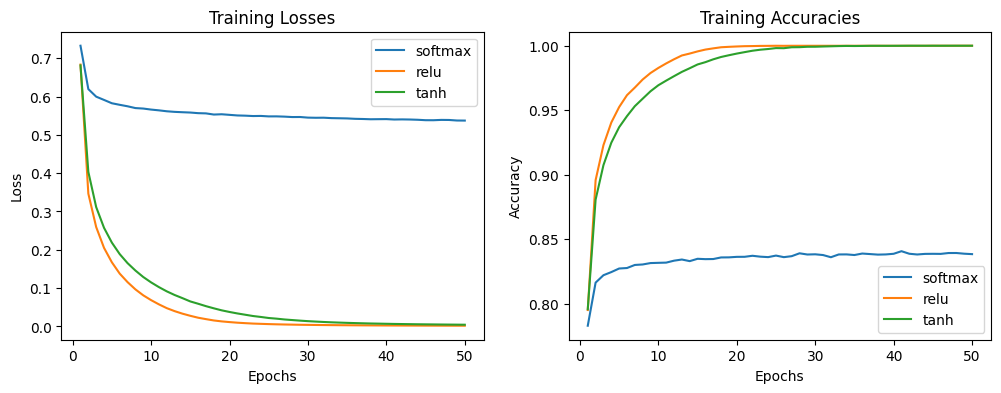

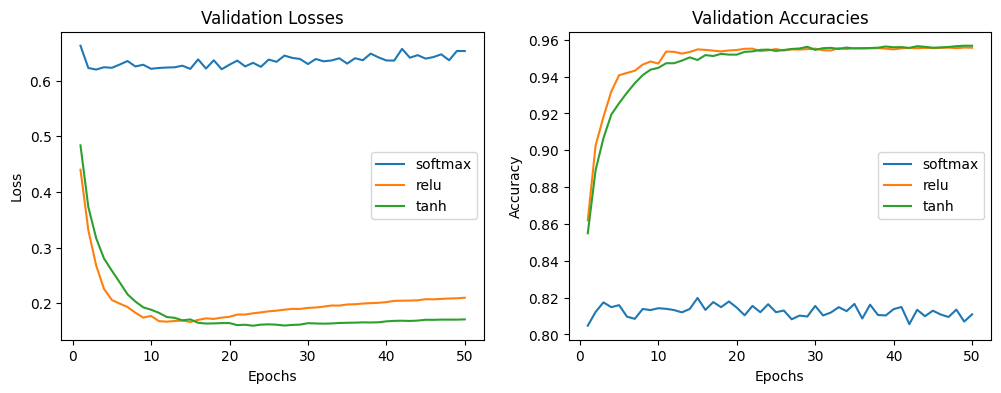

In [19]:
plot_metrics([[result_softmax.history['loss'],result_softmax.history['val_loss']], 
               [result_relu.history['loss'],result_relu.history['val_loss']], 
               [result_tanh.history['loss'],result_tanh.history['val_loss']]], 
             [[result_softmax.history['accuracy'],result_softmax.history['val_accuracy']], 
               [result_relu.history['accuracy'],result_relu.history['val_accuracy']], 
               [result_tanh.history['accuracy'],result_tanh.history['val_accuracy']]], 
             ['softmax', 'relu', 'tanh'])

#### Ініціалізації ваг Глоро та Хе

In [20]:
model_relu_he = MultimodelBase(X_train.shape[1:], y_train.shape[1], activation='relu', kernel_initializer = 'he_uniform')
model_relu_he.compile(optimizer=SGD(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

model_tanh_glorot = MultimodelBase(X_train.shape[1:], y_train.shape[1], activation='tanh', kernel_initializer = 'glorot_uniform')
model_tanh_glorot.compile(optimizer=SGD(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
result_relu_he = model_relu_he.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=0)
result_tanh_glorot = model_tanh_glorot.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=0)

Метрики ReLu з ініціалізацєю ваг Xe

In [22]:
print("loss: {}, \nval_loss: {}, \naccuracy: {}, \nval_accuracy: {}".format(result_relu_he.history['loss'][-1], 
                                                                      result_relu_he.history['val_loss'][-1], 
                                                                      result_relu_he.history['accuracy'][-1], 
                                                                      result_relu_he.history['val_accuracy'][-1]))

loss: 0.0017945535946637392, 
val_loss: 0.21724730730056763, 
accuracy: 0.999833345413208, 
val_accuracy: 0.9550833106040955


Метрики Tanh з ініціалізацією ваг Глоро

In [23]:
print("loss: {}, \nval_loss: {}, \naccuracy: {}, \nval_accuracy: {}".format(result_tanh_glorot.history['loss'][-1], 
                                                                      result_tanh_glorot.history['val_loss'][-1], 
                                                                      result_tanh_glorot.history['accuracy'][-1], 
                                                                      result_tanh_glorot.history['val_accuracy'][-1]))

loss: 0.004115160088986158, 
val_loss: 0.16921062767505646, 
accuracy: 0.999833345413208, 
val_accuracy: 0.9592499732971191


#### Функції активації LeakyReLu та ELU  

In [24]:
model_leaky_relu = MultimodelBase(X_train.shape[1:], y_train.shape[1], activation='leaky_relu', kernel_initializer = 'glorot_uniform')
model_leaky_relu.compile(optimizer=SGD(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

model_elu = MultimodelBase(X_train.shape[1:], y_train.shape[1], activation='elu', kernel_initializer = 'glorot_uniform')
model_elu.compile(optimizer=SGD(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
result_leaky_relu = model_leaky_relu.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=0)
result_elu = model_elu.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=0)

Метрики LeakyReLu

In [26]:
print("loss: {}, \nval_loss: {}, \naccuracy: {}, \nval_accuracy: {}".format(result_leaky_relu.history['loss'][-1], 
                                                                      result_leaky_relu.history['val_loss'][-1], 
                                                                      result_leaky_relu.history['accuracy'][-1], 
                                                                      result_leaky_relu.history['val_accuracy'][-1]))

loss: 0.002195178298279643, 
val_loss: 0.2132338285446167, 
accuracy: 0.999833345413208, 
val_accuracy: 0.9548333287239075


Метрики ELU

In [27]:
print("loss: {}, \nval_loss: {}, \naccuracy: {}, \nval_accuracy: {}".format(result_elu.history['loss'][-1], 
                                                                      result_elu.history['val_loss'][-1], 
                                                                      result_elu.history['accuracy'][-1], 
                                                                      result_elu.history['val_accuracy'][-1]))

loss: 0.00368297565728426, 
val_loss: 0.21351511776447296, 
accuracy: 0.9998124837875366, 
val_accuracy: 0.9548333287239075


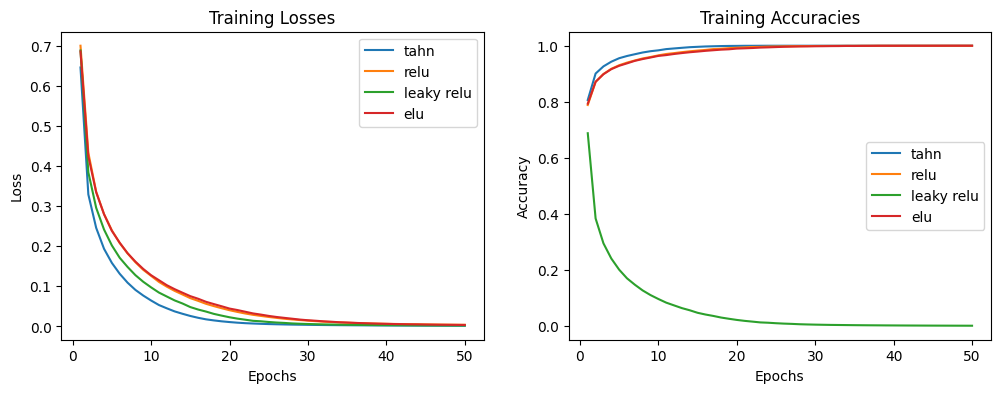

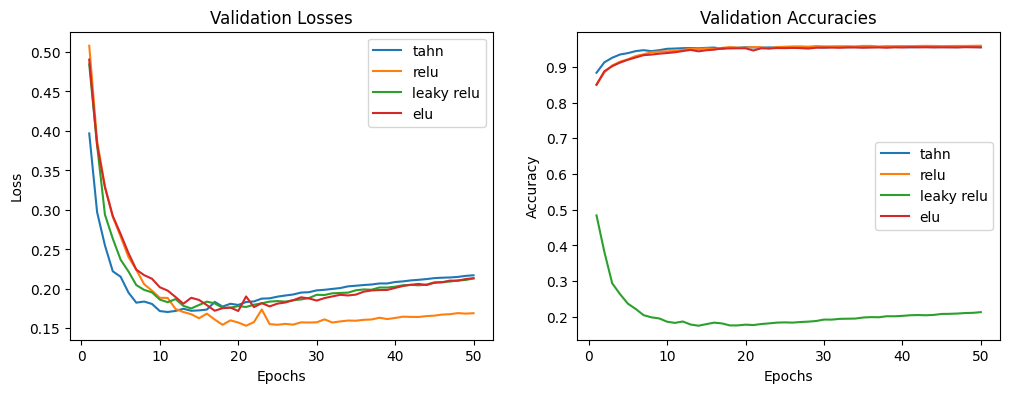

In [28]:
plot_metrics([[result_relu_he.history['loss'],result_relu_he.history['val_loss']], 
               [result_tanh_glorot.history['loss'],result_tanh_glorot.history['val_loss']], 
               [result_leaky_relu.history['loss'],result_leaky_relu.history['val_loss']],
               [result_elu.history['loss'],result_elu.history['val_loss']]], 
             [[result_relu_he.history['accuracy'],result_relu_he.history['val_accuracy']], 
               [result_tanh_glorot.history['accuracy'],result_tanh_glorot.history['val_accuracy']], 
               [result_leaky_relu.history['loss'],result_leaky_relu.history['val_loss']],
               [result_elu.history['accuracy'],result_elu.history['val_accuracy']]], 
             ['tahn', 'relu', 'leaky relu', 'elu'])

#### Адаптивні методи Adam, Adagrad, Adadelta

In [29]:
model_Adam = MultimodelBase(X_train.shape[1:], y_train.shape[1], activation='relu', kernel_initializer = 'glorot_uniform')
model_Adam.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

model_Adagrad = MultimodelBase(X_train.shape[1:], y_train.shape[1], activation='relu', kernel_initializer = 'glorot_uniform')
model_Adagrad.compile(optimizer=Adagrad(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

model_Adadelta = MultimodelBase(X_train.shape[1:], y_train.shape[1], activation='relu', kernel_initializer = 'glorot_uniform')
model_Adadelta.compile(optimizer=Adadelta(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])


In [30]:
result_Adam = model_Adam.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=0)
result_Adagrad = model_Adagrad.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=0)
result_Adadelta = model_Adadelta.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=0)

In [9]:
def metrics(model, X_test, y_test):
    predictions = model(X_test)
    loss = model.loss_function(y_test, predictions)
    correct_predictions = tf.equal(tf.argmax(predictions, 1), tf.argmax(y_test, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return loss.numpy(), accuracy.numpy()

Метрики Adam

In [31]:
print("loss: {}, \nval_loss: {}, \naccuracy: {}, \nval_accuracy: {}".format(result_Adam.history['loss'][-1], 
                                                                      result_Adam.history['val_loss'][-1], 
                                                                      result_Adam.history['accuracy'][-1], 
                                                                      result_Adam.history['val_accuracy'][-1]))

loss: 1.9519670009613037, 
val_loss: 1.9496253728866577, 
accuracy: 0.18277083337306976, 
val_accuracy: 0.1757500022649765


Метрики Adagrad

In [32]:
print("loss: {}, \nval_loss: {}, \naccuracy: {}, \nval_accuracy: {}".format(result_Adagrad.history['loss'][-1], 
                                                                      result_Adagrad.history['val_loss'][-1], 
                                                                      result_Adagrad.history['accuracy'][-1], 
                                                                      result_Adagrad.history['val_accuracy'][-1]))

loss: 0.0007746900664642453, 
val_loss: 0.20557783544063568, 
accuracy: 0.999833345413208, 
val_accuracy: 0.9628333449363708


Метрики Adadelta

In [33]:
print("loss: {}, \nval_loss: {}, \naccuracy: {}, \nval_accuracy: {}".format(result_Adadelta.history['loss'][-1], 
                                                                      result_Adadelta.history['val_loss'][-1], 
                                                                      result_Adadelta.history['accuracy'][-1], 
                                                                      result_Adadelta.history['val_accuracy'][-1]))

loss: 0.016504254192113876, 
val_loss: 0.17924544215202332, 
accuracy: 0.9984375238418579, 
val_accuracy: 0.9555000066757202


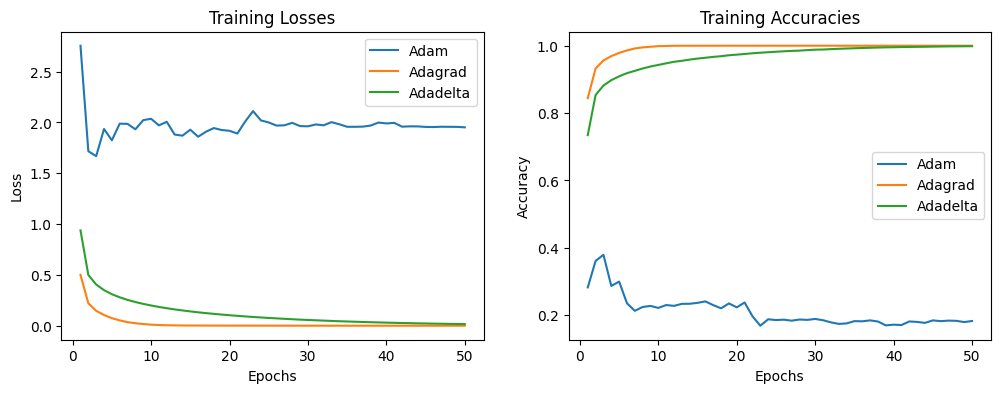

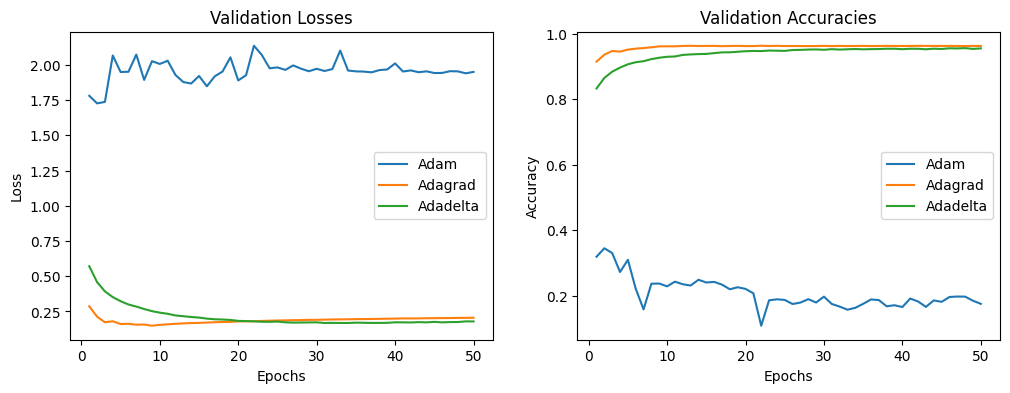

In [36]:
plot_metrics([[result_Adam.history['loss'],result_Adam.history['val_loss']], 
               [result_Adagrad.history['loss'],result_Adagrad.history['val_loss']],
               [result_Adadelta.history['loss'],result_Adadelta.history['val_loss']]], 
             [[result_Adam.history['accuracy'],result_Adam.history['val_accuracy']], 
               [result_Adagrad.history['accuracy'],result_Adagrad.history['val_accuracy']],
               [result_Adadelta.history['accuracy'],result_Adadelta.history['val_accuracy']]], 
             ['Adam', 'Adagrad', 'Adadelta'])

#### Моделі з нормалізацією за міні-батчами та дропаутом

In [37]:
class ModelWithNorm(Model):
    def __init__(self, input_shape, num_classes, activation, kernel_initializer):
        super(ModelWithNorm, self).__init__()
        self.norm1 = keras.layers.BatchNormalization()
        self.layer1 = keras.layers.Dense(256, input_shape=input_shape, activation=activation, kernel_initializer=kernel_initializer)
        self.norm2 = keras.layers.BatchNormalization()
        self.layer2 = keras.layers.Dense(128, activation=activation, kernel_initializer=kernel_initializer)
        self.norm3 = keras.layers.BatchNormalization()
        self.out = keras.layers.Dense(num_classes, activation='softmax')

    def call(self, x):
        x = self.norm1(x)
        x = self.layer1(x)
        x = self.norm2(x)
        x = self.layer2(x)
        x = self.norm3(x)
        return self.out(x)


In [40]:
class ModelWithDrop(Model):
    def __init__(self, input_shape, num_classes, activation, kernel_initializer):
        super(ModelWithDrop, self).__init__()
        self.dense1 = keras.layers.Dense(256, input_shape=input_shape, activation=activation, kernel_initializer=kernel_initializer)
        self.dense2 = keras.layers.Dense(128, activation=activation, kernel_initializer=kernel_initializer)
        self.dropout1 = keras.layers.Dropout(rate= 0.01)
        self.dense3 = keras.layers.Dense(num_classes, activation='softmax')

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dropout1(x)
        return self.dense3(x)

In [41]:
model_normalize = ModelWithNorm(X_train.shape[1:], y_train.shape[1], activation='relu', kernel_initializer = 'glorot_uniform')
model_normalize.compile(optimizer=SGD(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

model_drop = ModelWithDrop(X_train.shape[1:], y_train.shape[1], activation='relu', kernel_initializer = 'glorot_uniform')
model_drop.compile(optimizer=SGD(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
result_norm = model_normalize.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=0)
result_drop = model_drop.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=0)

Метрики для моедлі з нормалізацією

In [43]:
print("loss: {}, \nval_loss: {}, \naccuracy: {}, \nval_accuracy: {}".format(result_norm.history['loss'][-1], 
                                                                      result_norm.history['val_loss'][-1], 
                                                                      result_norm.history['accuracy'][-1], 
                                                                      result_norm.history['val_accuracy'][-1]))

loss: 0.00208541308529675, 
val_loss: 0.2141290307044983, 
accuracy: 0.9996458292007446, 
val_accuracy: 0.9544166922569275


Метрики для моделі з дропаутом

In [44]:
print("loss: {}, \nval_loss: {}, \naccuracy: {}, \nval_accuracy: {}".format(result_drop.history['loss'][-1], 
                                                                      result_drop.history['val_loss'][-1], 
                                                                      result_drop.history['accuracy'][-1], 
                                                                      result_drop.history['val_accuracy'][-1]))

loss: 0.0020650613587349653, 
val_loss: 0.20225276052951813, 
accuracy: 0.999833345413208, 
val_accuracy: 0.9570833444595337


#### Регуляризація L1 та L2

In [49]:
model_l1 = MultimodelBase(X_train.shape[1:], y_train.shape[1], activation='relu', kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l1(0.01))
model_l1.compile(optimizer=SGD(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

model_l2 = MultimodelBase(X_train.shape[1:], y_train.shape[1], activation='relu', kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(0.01))
model_l2.compile(optimizer=SGD(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
result_l1 = model_l1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=0)
result_l2 = model_l2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=0)

Метрики для L1

In [52]:
print("loss: {}, \nval_loss: {}, \naccuracy: {}, \nval_accuracy: {}".format(result_l1.history['loss'][-1], 
                                                                      result_l1.history['val_loss'][-1], 
                                                                      result_l1.history['accuracy'][-1], 
                                                                      result_l1.history['val_accuracy'][-1]))

loss: 2.326279878616333, 
val_loss: 2.244424343109131, 
accuracy: 0.7538958191871643, 
val_accuracy: 0.7803333401679993


Метрики для L1

In [53]:
print("loss: {}, \nval_loss: {}, \naccuracy: {}, \nval_accuracy: {}".format(result_l2.history['loss'][-1], 
                                                                      result_l2.history['val_loss'][-1], 
                                                                      result_l2.history['accuracy'][-1], 
                                                                      result_l2.history['val_accuracy'][-1]))

loss: 0.3191710412502289, 
val_loss: 0.5241698622703552, 
accuracy: 0.9476249814033508, 
val_accuracy: 0.8869166374206543


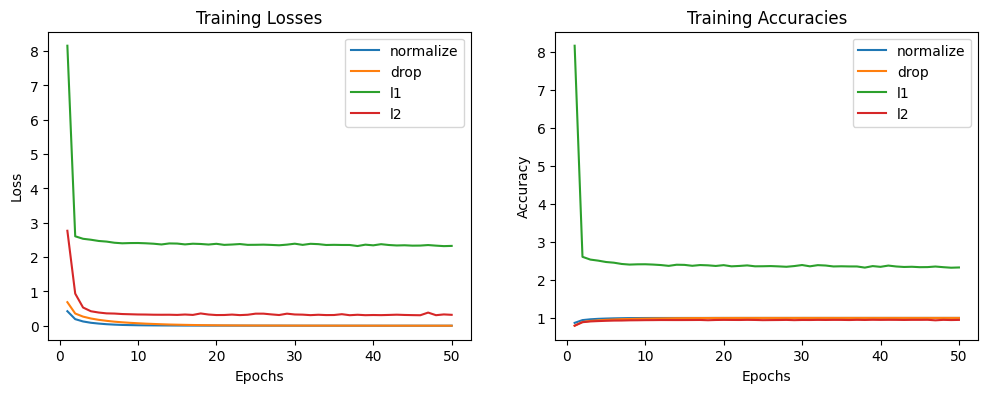

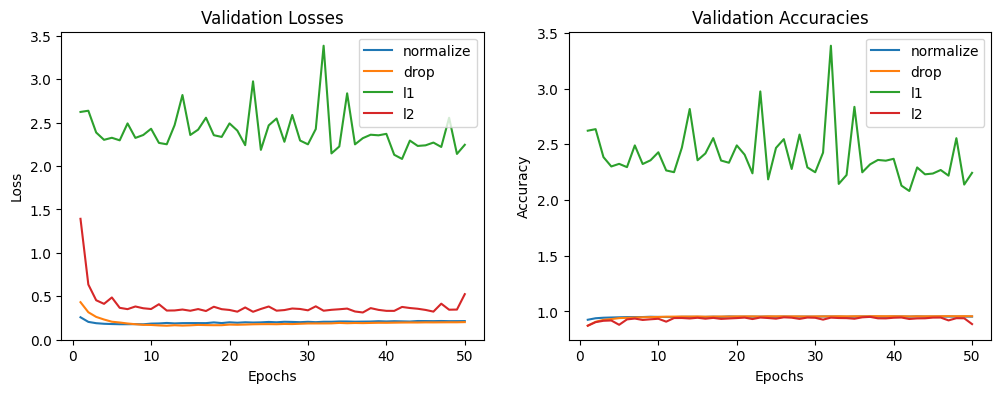

In [51]:
plot_metrics([[result_norm.history['loss'],result_norm.history['val_loss']], 
               [result_drop.history['loss'],result_drop.history['val_loss']], 
               [result_l1.history['loss'],result_l1.history['val_loss']],
               [result_l2.history['loss'],result_l2.history['val_loss']]], 
             [[result_norm.history['accuracy'],result_norm.history['val_accuracy']], 
               [result_drop.history['accuracy'],result_drop.history['val_accuracy']], 
               [result_l1.history['loss'],result_l1.history['val_loss']],
               [result_l2.history['accuracy'],result_l2.history['val_accuracy']]], 
             ['normalize', 'drop', 'l1', 'l2'])

#### Вибір найкращої моделі

In [54]:
def metrics(model, X_test, y_test):
    y_pred = model.predict(X_test, verbose=0)
    return f1_score(y_test, np.argmax(y_pred, axis=1), average='macro'), roc_auc_score(y_test, y_pred, average='macro', multi_class='ovo')

In [66]:
models_list = [model_softmax, model_relu, model_tanh, model_relu_he, model_tanh_glorot, model_leaky_relu, model_elu, 
               model_Adam, model_Adagrad, model_Adadelta, model_normalize, model_drop, model_l1, model_l2]
          

metrics_list = []
for model in models_list:
    metrics_list.append(metrics(model, X_test, y_test_graph))

In [67]:
metrics_list

[(0.6902343545138556, 0.93841445),
 (0.8912021161337884, 0.9905019333333331),
 (0.8951923838220541, 0.9906756944444447),
 (0.8908139119585845, 0.9904866277777777),
 (0.89561694707066, 0.9910026388888888),
 (0.8904659823850369, 0.9902595555555554),
 (0.8897844530920123, 0.9901529944444445),
 (0.05836916706481924, 0.6096479333333332),
 (0.9038025240425395, 0.9917400111111111),
 (0.8856143600594752, 0.9892420055555555),
 (0.8922134680132284, 0.9906406333333335),
 (0.8968574861352344, 0.9902828277777777),
 (0.6340705003929843, 0.9347802777777777),
 (0.8135962068363618, 0.981197061111111)]

#### Перевірка на тестовому наборі

In [68]:
y_pred = model_Adagrad.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [69]:
predicted_classes = np.argmax(y_pred, axis=1)

In [70]:
predicted_classes

array([2, 9, 3, ..., 9, 4, 2], dtype=int64)

In [71]:
y_test_graph

array([2, 9, 3, ..., 9, 4, 2], dtype=int64)

#### Перевірка на рукописному символі

In [97]:
image = Image.open('C:/Users/User/Desktop/Dataset/test.png').resize((28, 28)).convert('L')
image = (np.array(image) / 255).reshape(28,28)
label = tf.keras.utils.to_categorical(0, y_train.shape[1])

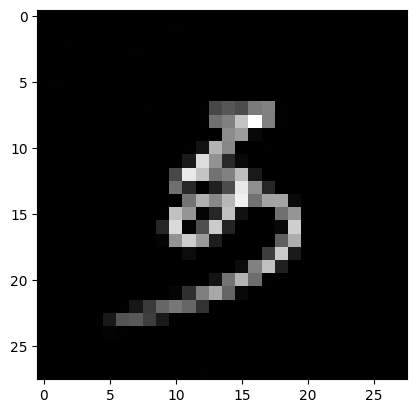

In [98]:
plt.imshow(image, cmap='Greys')

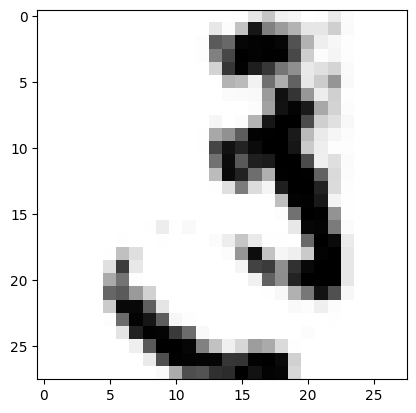

In [103]:
predicted_probs = model_Adagrad.predict(np.array([image]), verbose=0)
predicted_class = np.argmax(predicted_probs, axis=1)[0]

image_index = np.argmax(predicted_probs)

image_with_highest_prob = X_train[image_index]

plt.imshow(image_with_highest_prob.reshape(28, 28), cmap='Greys')
plt.show()

#### Класифікація набору кольорових зображень типу CIFAR10

In [126]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_test1 = y_test
y_train1 = y_train

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


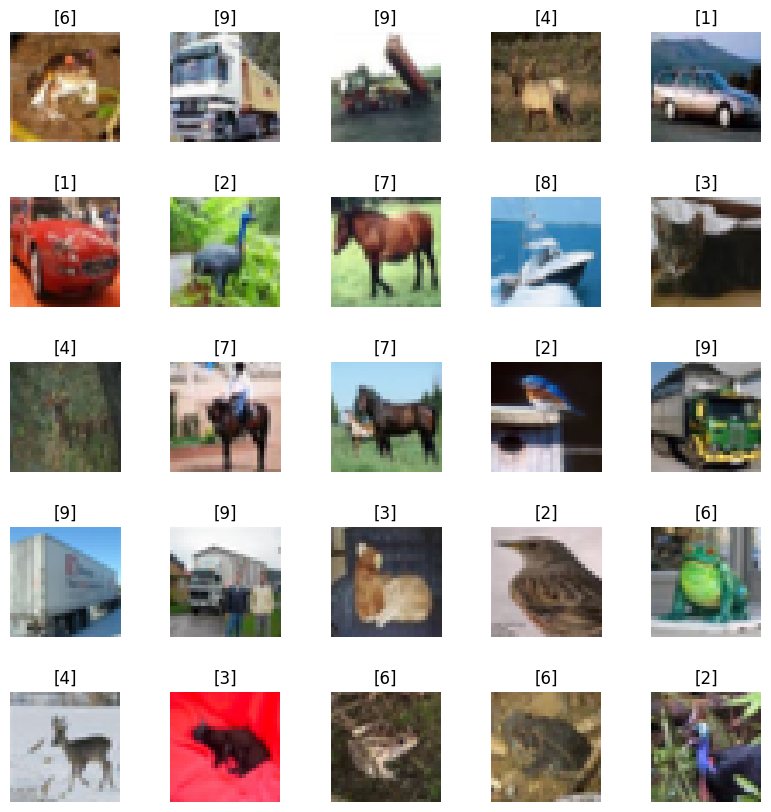

In [127]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10,10))
axes = axes.ravel()
for i in np.arange(0, 25):
    axes[i].imshow(X_train[i])
    axes[i].set_title(y_train1[i])
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.5)
plt.show()

In [130]:
from tensorflow.keras.utils import to_categorical

X_train = X_train.reshape((50000, 3072))
X_train = X_train.astype('float32') / 255.0
X_test = X_test.reshape((10000, 3072))
X_test = X_test.astype('float32') / 255.0

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

model_Adagrad_cifar = MultimodelBase(X_train.shape[1:], y_train.shape[1], activation='relu', kernel_initializer='glorot_uniform')
model_Adagrad_cifar.compile(optimizer=Adadelta(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
result_Adagrad_cifar = model_Adagrad_cifar.fit(X_train, y_train, batch_size=batch_size, epochs=100, validation_split=0.2, verbose=0)


In [136]:
for i in range(0, len(result_Adagrad_cifar.history['accuracy']), 9):
    epoch = i + 1
    loss = result_Adagrad_cifar.history['loss'][i]
    accuracy = result_Adagrad_cifar.history['accuracy'][i]
    val_loss = result_Adagrad_cifar.history['val_loss'][i]
    val_accuracy = result_Adagrad_cifar.history['val_accuracy'][i]
    print(f"Epoch {epoch}:")
    print(f"  - Loss: {loss}")
    print(f"  - Accuracy: {accuracy}")
    print(f"  - Validation Loss: {val_loss}")
    print(f"  - Validation Accuracy: {val_accuracy}")

Epoch 1:
  - Loss: 1.9565998315811157
  - Accuracy: 0.29554998874664307
  - Validation Loss: 1.8868041038513184
  - Validation Accuracy: 0.32100000977516174
Epoch 10:
  - Loss: 1.4728407859802246
  - Accuracy: 0.4809249937534332
  - Validation Loss: 1.5467429161071777
  - Validation Accuracy: 0.4578999876976013
Epoch 19:
  - Loss: 1.333748698234558
  - Accuracy: 0.5304750204086304
  - Validation Loss: 1.5403270721435547
  - Validation Accuracy: 0.4699999988079071
Epoch 28:
  - Loss: 1.2290077209472656
  - Accuracy: 0.5685999989509583
  - Validation Loss: 1.46977698802948
  - Validation Accuracy: 0.4912000000476837
Epoch 37:
  - Loss: 1.1395552158355713
  - Accuracy: 0.6020249724388123
  - Validation Loss: 1.3929343223571777
  - Validation Accuracy: 0.5194000005722046
Epoch 46:
  - Loss: 1.0589919090270996
  - Accuracy: 0.6306999921798706
  - Validation Loss: 1.4803507328033447
  - Validation Accuracy: 0.49880000948905945
Epoch 55:
  - Loss: 0.987249493598938
  - Accuracy: 0.65822499990

#### Висновки

Було досліджено два набори даних типу MNIST та CIFAR10 за допомогою моедлей із різною кількістю взідних шарів і різноманітними функціями активації, регуляризації, ініціалізації та адаптивних методів. За результатами можна сказати наступне:
1. Методи ініціалізації Глюро та Хе дають дуже схожі показники accuracy
2. Моделі майже не показують ознак перенавчання
3. Після використання даптивних алгоритмів оптимізації показники навчання дещо покращилися
4. Найкращою моделлю виявилася мережа з багатьма вхідними шарами з адаптивним методом Adagrad
5. Багатошаровий персептрон не справляється з задачею класифікації кольорових зображень